# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from itertools import islice

sys.path.append("Codes/")
import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input\Real\BPI Challenge 2020/*.xes.gz")

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  5


,0
0,Input\Real\BPI Challenge 2020\DomesticDeclarations.xes.gz
1,Input\Real\BPI Challenge 2020\InternationalDeclarations.xes.gz
2,Input\Real\BPI Challenge 2020\PermitLog.xes.gz
3,Input\Real\BPI Challenge 2020\PrepaidTravelCost.xes.gz
4,Input\Real\BPI Challenge 2020\RequestForPayment.xes.gz


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[0]
print(log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_xes(log_path)

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Renaming columns to match the expected format
event_log = event_log.rename(columns={
    'org:resource': 'resource',
    'org:role': 'role',
    'case:BudgetNumber': 'BudgetNumber',
    'case:Amount': 'Amount'
})

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('case:id')))
print("Total activities: ", len(event_log.groupby('concept:name')))
event_log.head()

DomesticDeclarations


parsing log, completed traces :: 100%|██████████| 10500/10500 [00:01<00:00, 10451.68it/s]


Total events:  56437
Total cases:  10500
Total activities:  17


,original_index,id,resource,concept:name,time:timestamp,role,case:id,case:concept:name,BudgetNumber,case:DeclarationNumber,Amount
0,0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+00:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
1,1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+00:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
2,2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
3,3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 17:31:22+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
4,4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14+00:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.4642


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='case:id', activity_key='concept:name', timestamp_key='time:timestamp', timestamp_format=None, other_columns_keys=["role", "resource", "BudgetNumber", "Amount"])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head()

66937


,case_id,activity_from,timestamp_from,role_from,resource_from,BudgetNumber_from,Amount_from,event_order_from,activity_to,timestamp_to,role_to,resource_to,BudgetNumber_to,Amount_to,event_order_to,case_order,transition_id
0,declaration 86791,START,2017-01-09 09:49:50+00:00,EMPLOYEE,STAFF MEMBER,budget 86566,26.8512,0,Declaration_SUBMITTED_by_EMPLOYEE,2017-01-09 09:49:50+00:00,EMPLOYEE,STAFF MEMBER,budget 86566,26.8512,0.0000,0,0
1,declaration 86791,Declaration_SUBMITTED_by_EMPLOYEE,2017-01-09 09:49:50+00:00,EMPLOYEE,STAFF MEMBER,budget 86566,26.8512,0,Declaration_FINAL_APPROVED_by_SUPERVISOR,2017-01-09 11:27:48+00:00,SUPERVISOR,STAFF MEMBER,budget 86566,26.8512,1.0000,1,1
2,declaration 86791,Declaration_FINAL_APPROVED_by_SUPERVISOR,2017-01-09 11:27:48+00:00,SUPERVISOR,STAFF MEMBER,budget 86566,26.8512,1,Request_Payment,2017-01-10 09:34:44+00:00,UNDEFINED,SYSTEM,budget 86566,26.8512,2.0000,2,2
3,declaration 86791,Request_Payment,2017-01-10 09:34:44+00:00,UNDEFINED,SYSTEM,budget 86566,26.8512,2,Payment_Handled,2017-01-12 17:31:22+00:00,UNDEFINED,SYSTEM,budget 86566,26.8512,3.0000,3,3
4,declaration 86791,Payment_Handled,2017-01-12 17:31:22+00:00,UNDEFINED,SYSTEM,budget 86566,26.8512,3,END,2017-01-12 17:31:22+00:00,UNDEFINED,SYSTEM,budget 86566,26.8512,3.0000,4,4


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 2000, window_ref_mode = "Fixed", overlap = True, sliding_step = 1000, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items()))

{0: {'start': 0, 'end': 2000},
 1: {'start': 1000, 'end': 3000},
 2: {'start': 2000, 'end': 4000},
 3: {'start': 3000, 'end': 5000},
 4: {'start': 4000, 'end': 6000},
 5: {'start': 5000, 'end': 7000},
 6: {'start': 6000, 'end': 8000},
 7: {'start': 7000, 'end': 9000},
 8: {'start': 8000, 'end': 10000},
 9: {'start': 9000, 'end': 11000},
 10: {'start': 10000, 'end': 12000},
 11: {'start': 11000, 'end': 13000},
 12: {'start': 12000, 'end': 14000},
 13: {'start': 13000, 'end': 15000},
 14: {'start': 14000, 'end': 16000},
 15: {'start': 15000, 'end': 17000},
 16: {'start': 16000, 'end': 18000},
 17: {'start': 17000, 'end': 19000},
 18: {'start': 18000, 'end': 20000},
 19: {'start': 19000, 'end': 21000},
 20: {'start': 20000, 'end': 22000},
 21: {'start': 21000, 'end': 23000},
 22: {'start': 22000, 'end': 24000},
 23: {'start': 23000, 'end': 25000},
 24: {'start': 24000, 'end': 26000},
 25: {'start': 25000, 'end': 27000},
 26: {'start': 26000, 'end': 28000},
 27: {'start': 27000, 'end': 290

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0.005
                                    , control_flow_features={'frequency', 'probability'} #, 'probability', 'causality', 'parallel'
                                    , time_features={('time_avg','timestamp'), ('time_std','timestamp')}
                                    , resource_features={('categorical_encoding_frequency', 'role')#, ('categorical_encoding_probability', 'role')
                                                        #  , ('categorical_unique', 'role'), ('categorical_entropy', 'role')
                                                         , ('categorical_encoding_frequency', 'resource')#, ('categorical_encoding_probability', 'resource')
                                                        # , ('categorical_unique', 'resource'), ('categorical_entropy', 'resource')
                                                         } 
                                    , data_features={('numerical_avg', 'Amount'), ('numerical_std', 'Amount')
                                                        , ('categorical_unique', 'BudgetNumber'), ('categorical_entropy', 'BudgetNumber')
                                                        # , ('categorical_encoding_frequency', 'BudgetNumber'), ('categorical_encoding_probability', 'BudgetNumber')
                                                    }
                                    )

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation()#.head(15)

frequency  \
activity_from                            activity_to                                           
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER           2820   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR       5133   
Declaration_APPROVED_by_BUDGET_OWNER     Declaration_FINAL_APPROVED_by_SUPERVISOR       2788   
Declaration_APPROVED_by_PRE_APPROVER     Declaration_FINAL_APPROVED_by_SUPERVISOR        674   
Declaration_FINAL_APPROVED_by_SUPERVISOR Request_Payment                               10038   
Declaration_REJECTED_by_ADMINISTRATION   Declaration_REJECTED_by_EMPLOYEE                928   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE              1081   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_ADMINISTRATION         8202   
                                         Declaration_APPROVED_by_PRE_APPROVER            685   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR       1536   
                                         Declaration_REJECTED_by_ADMINISTRATION          952   
Payment_Handled                          END                                           10043   
Request_Payment                          Payment_Handled                               10037   
START                                    Declaration_SUBMITTED_by_EMPLOYEE             10365   

                                                                                   percentual  \
activity_from                            activity_to                                            
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER          0.0421   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0767   
Declaration_APPROVED_by_BUDGET_OWNER     Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0417   
Declaration_APPROVED_by_PRE_APPROVER     Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0101   
Declaration_FINAL_APPROVED_by_SUPERVISOR Request_Payment                               0.1500   
Declaration_REJECTED_by_ADMINISTRATION   Declaration_REJECTED_by_EMPLOYEE              0.0139   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE             0.0161   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_ADMINISTRATION        0.1225   
                                         Declaration_APPROVED_by_PRE_APPROVER          0.0102   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0229   
                                         Declaration_REJECTED_by_ADMINISTRATION        0.0142   
Payment_Handled                          END                                           0.1500   
Request_Payment                          Payment_Handled                               0.1499   
START                                    Declaration_SUBMITTED_by_EMPLOYEE             0.1548   

                                                                                   probability  \
activity_from                            activity_to                                             
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER           0.3546   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR       0.6454   
Declaration_APPROVED_by_BUDGET_OWNER     Declaration_FINAL_APPROVED_by_SUPERVISOR       1.0000   
Declaration_APPROVED_by_PRE_APPROVER     Declaration_FINAL_APPROVED_by_SUPERVISOR       1.0000   
Declaration_FINAL_APPROVED_by_SUPERVISOR Request_Payment                                1.0000   
Declaration_REJECTED_by_ADMINISTRATION   Declaration_REJECTED_by_EMPLOYEE               1.0000   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE              1.0000   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_ADMINISTRATION         0.7211   
             

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            ### Control Flow Perspective
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}

            ### Time Perspective
            , 'time_avg_delta' : {'process_feature':'time_avg_timestamp', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'time_std_delta' : {'process_feature':'time_std_timestamp', 'method':'aggregation', 'agg_function' : 'sum'}

            ### Resource Perspective
            # , 'role_unique_delta' : {'process_feature':'categorical_unique_role', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'role_entropy_delta' : {'process_feature':'categorical_entropy_role', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'role_encoding_frequency_delta' : {'process_feature':'categorical_encoding_frequency_role', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
            # , 'role_encoding_probability_delta' : {'process_feature':'categorical_encoding_probability_role', 'method':'multiple_aggregation', 'agg_function' : 'sum'}

            #  , 'resource_unique_delta' : {'process_feature':'categorical_unique_resource', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'resource_entropy_delta' : {'process_feature':'categorical_entropy_resource', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'resource_encoding_frequency_delta' : {'process_feature':'categorical_encoding_frequency_resource', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
            # , 'resource_encoding_probability_delta' : {'process_feature':'categorical_encoding_probability_resource', 'method':'multiple_aggregation', 'agg_function' : 'sum'}

            ### Data Perspective
            , 'amount_avg_delta' : {'process_feature':'numerical_avg_Amount', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'amount_std_delta' : {'process_feature':'numerical_std_Amount', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'BudgetNumber_unique_delta' : {'process_feature':'categorical_unique_BudgetNumber', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'BudgetNumber_entropy_delta' : {'process_feature':'categorical_entropy_BudgetNumber', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'BudgetNumber_encoding_frequency_delta' : {'process_feature':'categorical_encoding_frequency_BudgetNumber', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
            # , 'BudgetNumber_encoding_probability_delta' : {'process_feature':'categorical_encoding_probability_BudgetNumber', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            ### Control Flow Perspective
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head()

,start,end,reference_window_index,frequency_delta,prob_freq_delta_weight,time_avg_delta,time_std_delta,role_encoding_frequency_delta,resource_encoding_frequency_delta,amount_avg_delta,BudgetNumber_unique_delta,BudgetNumber_entropy_delta,frequency_gtest_pvalue,frequency_cramersv
0,0,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000,3000,0.0000,152.0000,29.9189,53307.4376,103267.8298,608.0000,608.0000,417.6570,3.0000,0.0000,1.0000,0.0000
2,2000,4000,0.0000,201.0000,25.4395,55978.0634,191899.5883,3216.0000,3216.0000,645.0337,2.0000,0.0000,1.0000,0.0000
3,3000,5000,0.0000,186.0000,33.7029,59384.3833,201588.1887,2976.0000,2976.0000,608.7935,3.0000,0.0000,1.0000,0.0000
4,4000,6000,0.0000,160.0000,28.7308,93092.3490,331669.8002,2560.0000,2560.0000,560.7943,3.0000,0.0000,1.0000,0.0000


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        ### Control Flow Perspective
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'

        ### Time Perspective
        , 'cpd_time_avg_delta' : {'change_features':['time_avg_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'

        ### Resource Perspective
        # , 'cpd_role_unique_delta' : {'change_features':['role_unique_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_role_entropy_delta' : {'change_features':['role_entropy_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_role_encoding_frequency_delta' : {'change_features':['role_encoding_frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_role_encoding_probability_delta' : {'change_features':['role_encoding_probability_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'

        # , 'cpd_resource_unique_delta' : {'change_features':['resource_unique_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        # , 'cpd_resource_entropy_delta' : {'change_features':['resource_entropy_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        , 'cpd_resource_encoding_frequency_delta' : {'change_features':['resource_encoding_frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        # , 'cpd_resource_encoding_probability_delta' : {'change_features':['resource_encoding_probability_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1

        ### Data Perspective
        , 'cpd_amount_avg_delta' : {'change_features':['amount_avg_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_amount_std_delta' : {'change_features':['amount_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_BudgetNumber_unique_delta' : {'change_features':['BudgetNumber_unique_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        , 'cpd_BudgetNumber_entropy_delta' : {'change_features':['BudgetNumber_entropy_delta'], 'method':'cpd_pelt', 'smooth' : '3', 'pen': '5'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        # , 'cpd_BudgetNumber_encoding_frequency_delta' : {'change_features':['BudgetNumber_encoding_frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        # , 'cpd_BudgetNumber_encoding_probability_delta' : {'change_features':['BudgetNumber_encoding_probability_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[14, 65]"
1,time_series_strategy,cpd_prob_freq_delta,"[15, 65]"
2,time_series_strategy,cpd_time_avg_delta,"[14, 28, 65]"
3,time_series_strategy,cpd_time_std_delta,"[15, 46, 65]"
4,time_series_strategy,cpd_role_encoding_frequency_delta,"[13, 65]"
5,time_series_strategy,cpd_resource_encoding_frequency_delta,"[14, 65]"
6,time_series_strategy,cpd_amount_avg_delta,"[12, 65]"
7,time_series_strategy,cpd_BudgetNumber_unique_delta,"[14, 65]"
8,time_series_strategy,cpd_BudgetNumber_entropy_delta,[65]
9,threshold_strategy,gtest_frequency,[65]


In [9]:
### Grounding truth
# No ground truth available for real dataset. Skipping this step.

In [10]:
### Validation metrics
# No ground truth available for real dataset. Skipping validation metrics calculation.

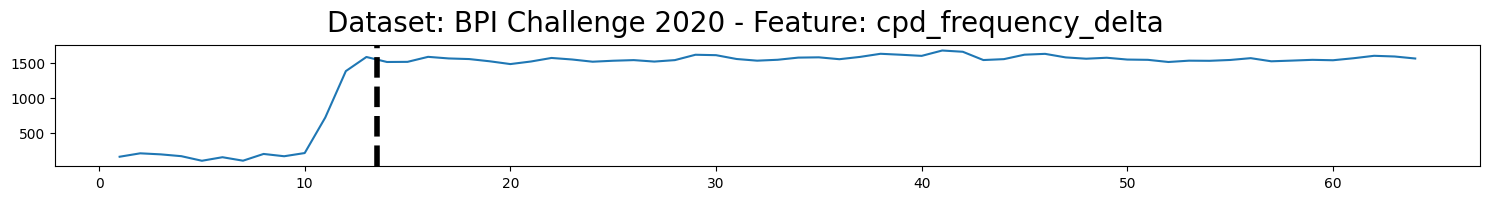

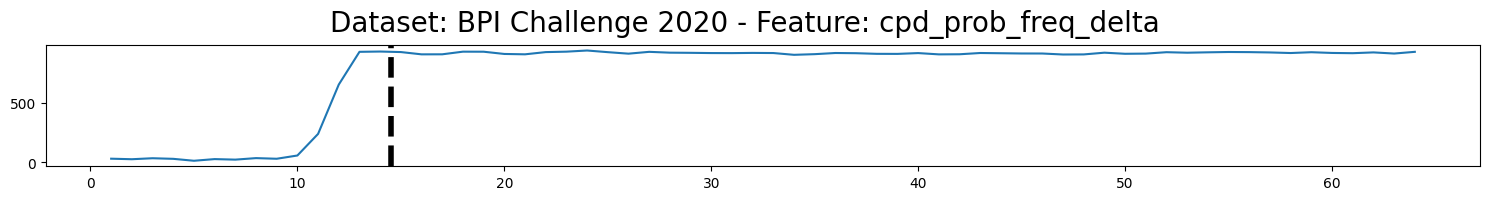

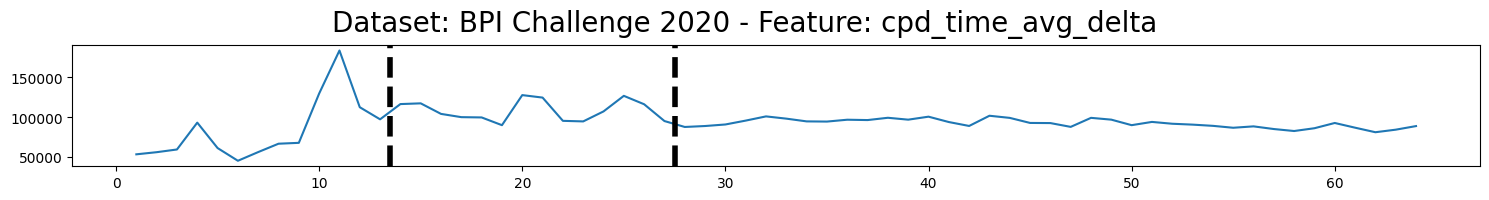

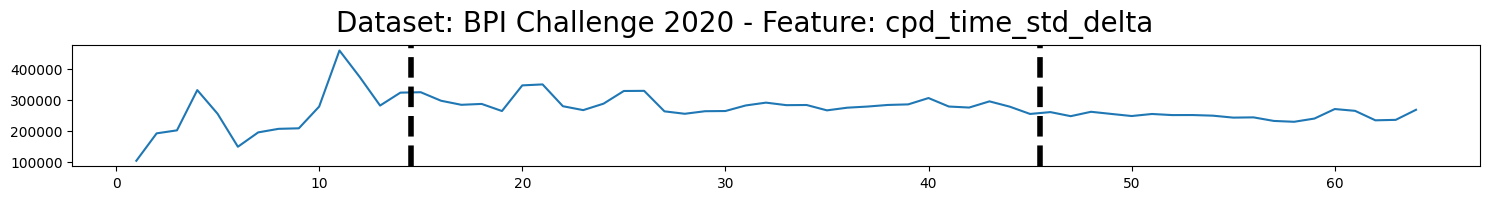

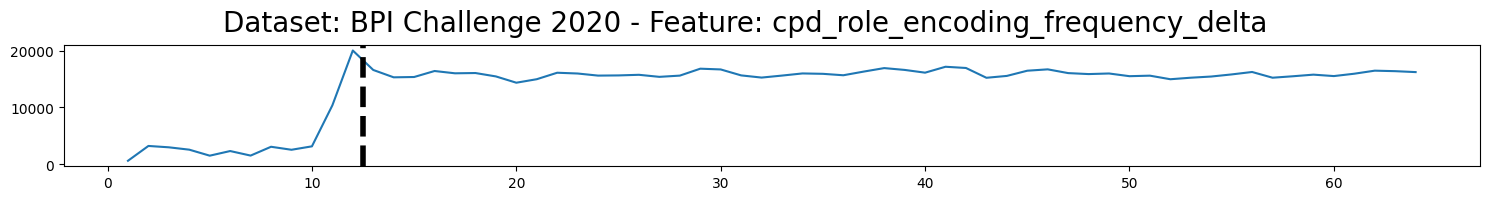

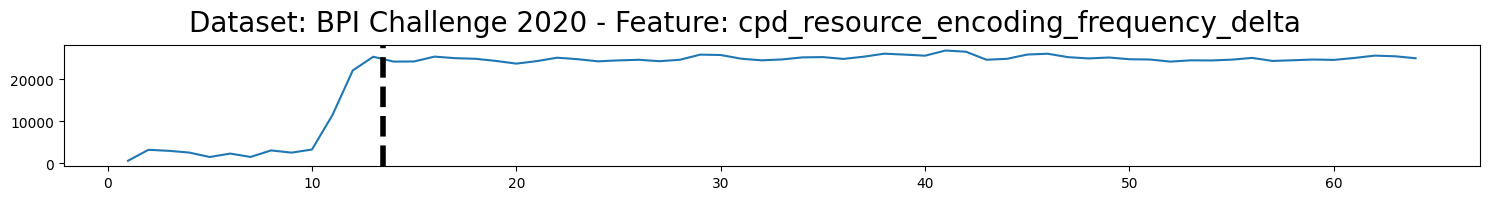

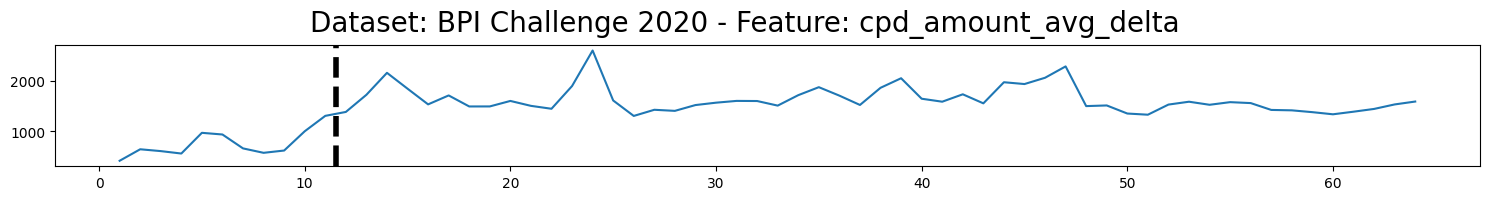

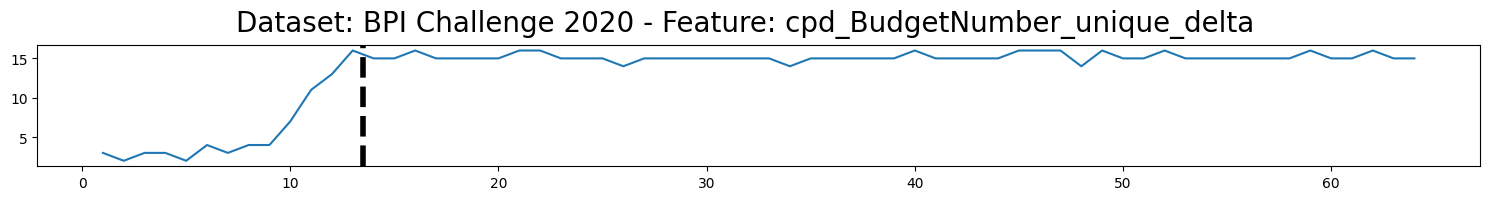

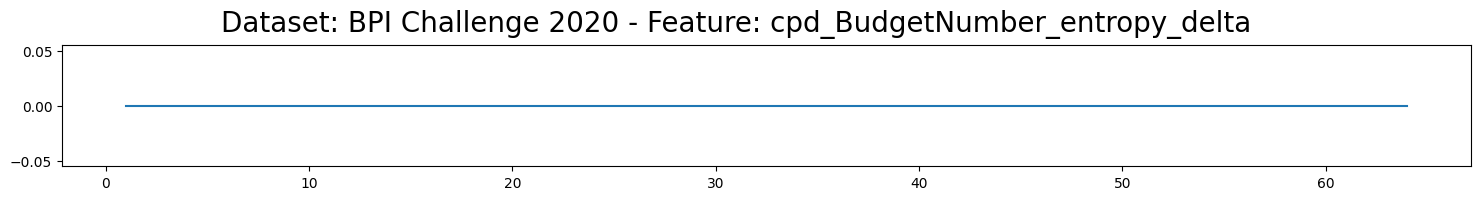

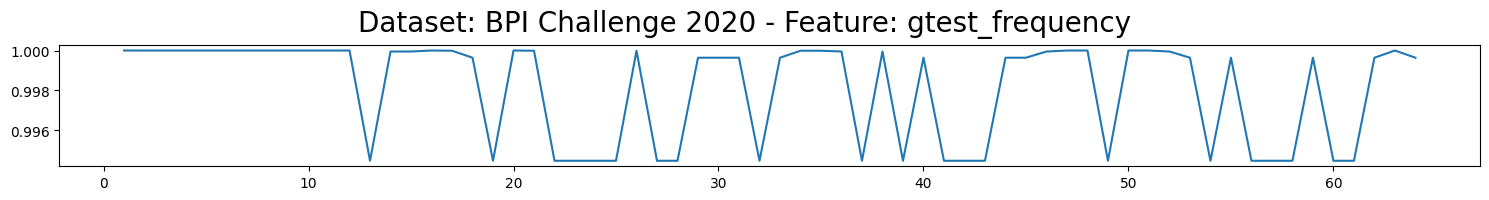

In [11]:
### Display Detection Task Results 
detection_task_results = TMPD_instance.get_detection_task()
for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(
        signal=TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']],
        true_chg_pts=[],  # Provide empty list when no ground truth
        computed_chg_pts=result.detection_results,
        computed_chg_pts_color="k",
        computed_chg_pts_linewidth=4,
        computed_chg_pts_linestyle="--",
        computed_chg_pts_alpha=1,
        figsize=(15, 2)
    )
    plt.suptitle(
        "Dataset: " + log_path.split("\\")[-2]
        + " - Feature: " + result.detection_feature,
        fontsize=20
    )
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

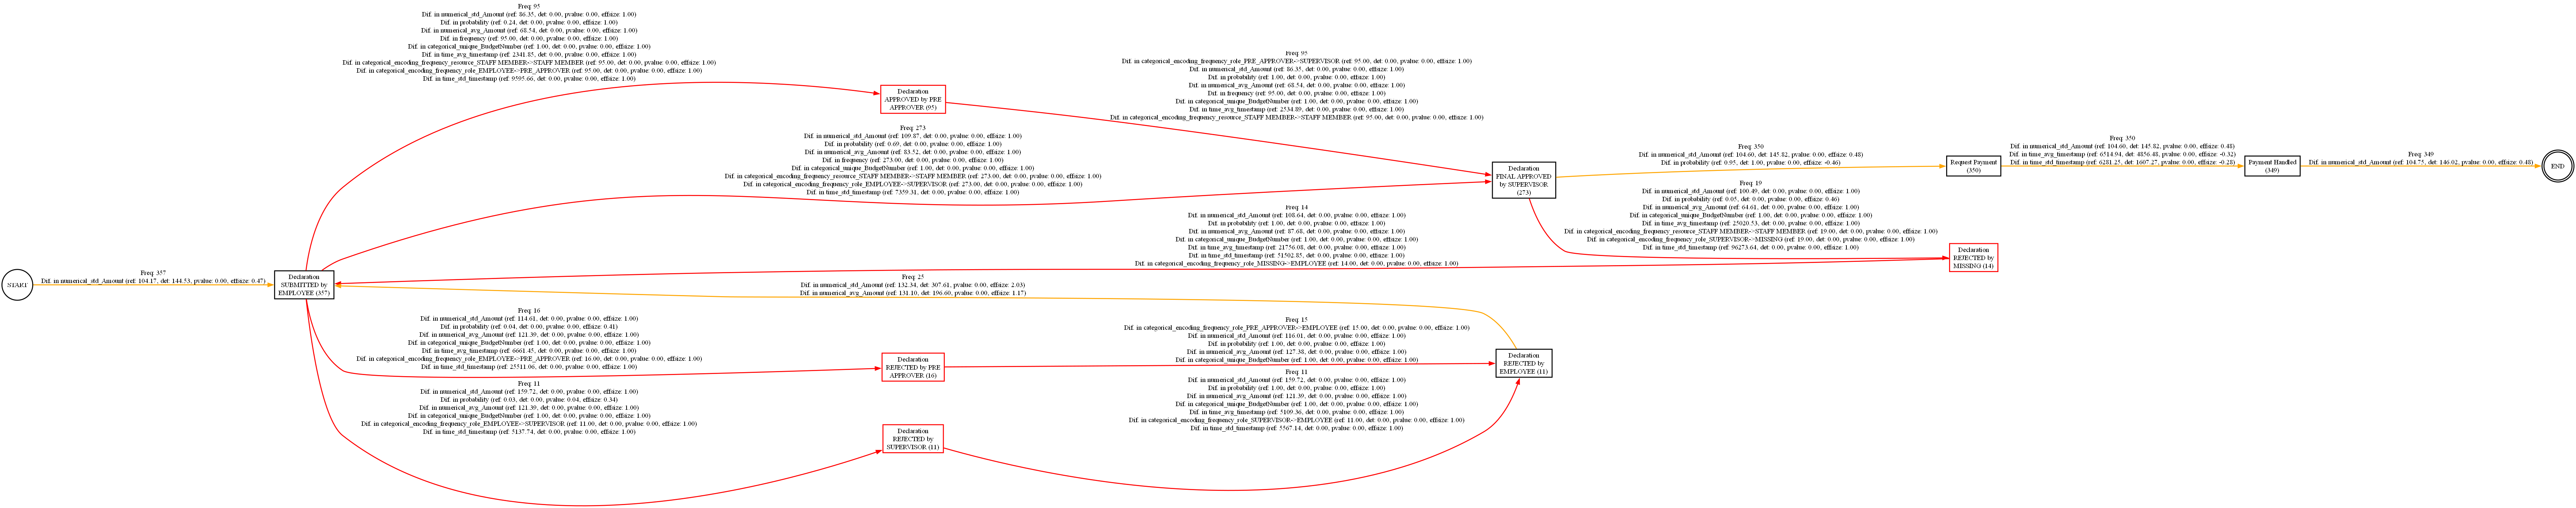

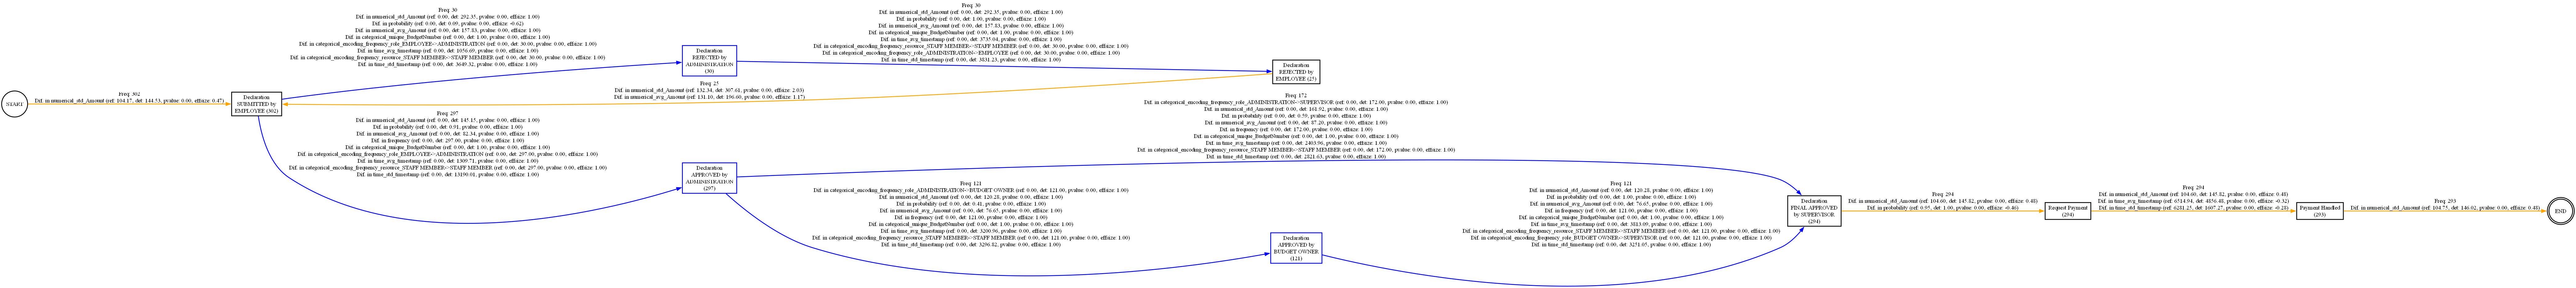

In [12]:
# Setting Localization Task
reference_window_index=0 
detection_window_index=55

TMPD_instance.set_localization_task(reference_window_index=reference_window_index, detection_window_index=detection_window_index, pvalue_threshold=0.05, effect_threshold=0.2, presence_percentage_threshold=0.02, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
changed_transitions, change_informations, reference_bpmn_text, detection_bpmn_text = TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=False)

In [13]:
# target_transitions = [
#     ('Declaration_SUBMITTED_by_EMPLOYEE', 'Declaration_APPROVED_by_ADMINISTRATION'),
#     ('Declaration_SUBMITTED_by_EMPLOYEE', 'Declaration_APPROVED_by_PRE_APPROVER'),
#     # add more transitions as needed
# ]
# changed_transitions[changed_transitions['transition'].isin(target_transitions)]

changed_transitions

,transition,feature,perspective,transition_status,activity_status,p_value,effect_size,ref_value,det_value,dif_value
0,"(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",categorical_encoding_frequency_role_ADMINISTRATION->BUDGET OWNER,resource,new,"new(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",0.0000,1.0000,0.0000,121.0000,121.0000
1,"(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",numerical_std_Amount,data,new,"new(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",0.0000,1.0000,0.0000,120.2813,120.2813
2,"(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",probability,control_flow,new,"new(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",0.0000,1.0000,0.0000,0.4130,0.4130
3,"(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",numerical_avg_Amount,data,new,"new(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",0.0000,1.0000,0.0000,76.6498,76.6498
4,"(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",frequency,control_flow,new,"new(Declaration_APPROVED_by_ADMINISTRATION, Declaration_APPROVED_by_BUDGET_OWNER)",0.0000,1.0000,0.0000,121.0000,121.0000
...,...,...,...,...,...,...,...,...,...,...
121,"(Payment_Handled, END)",numerical_std_Amount,data,significant difference,no change,0.0000,0.4781,104.7542,146.0188,41.2647
122,"(Request_Payment, Payment_Handled)",numerical_std_Amount,data,significant difference,no change,0.0000,0.4776,104.6040,145.8211,41.2170
123,"(Request_Payment, Payment_Handled)",time_avg_timestamp,time,significant difference,no change,0.0000,-0.3243,6514.9430,4856.4804,-1658.4626
124,"(Request_Payment, Payment_Handled)",time_std_timestamp,time,significant difference,no change,0.0003,-0.2800,6281.2546,1607.2670,-4673.9877


In [14]:
change_informations

{'Transitions with variations in categorical_encoding_frequency_role_PRE_APPROVER->SUPERVISOR': [('Declaration_APPROVED_by_PRE_APPROVER',
   'Declaration_FINAL_APPROVED_by_SUPERVISOR')],
 'Transitions with variations in categorical_encoding_frequency_role_ADMINISTRATION->SUPERVISOR': [('Declaration_APPROVED_by_ADMINISTRATION',
   'Declaration_FINAL_APPROVED_by_SUPERVISOR')],
 'Transitions with variations in categorical_encoding_frequency_role_PRE_APPROVER->EMPLOYEE': [('Declaration_REJECTED_by_PRE_APPROVER',
   'Declaration_REJECTED_by_EMPLOYEE')],
 'Transitions with variations in categorical_encoding_frequency_role_ADMINISTRATION->BUDGET OWNER': [('Declaration_APPROVED_by_ADMINISTRATION',
   'Declaration_APPROVED_by_BUDGET_OWNER')],
 'Transitions with variations in numerical_std_Amount': [('Declaration_APPROVED_by_ADMINISTRATION',
   'Declaration_APPROVED_by_BUDGET_OWNER'),
  ('Declaration_APPROVED_by_ADMINISTRATION',
   'Declaration_FINAL_APPROVED_by_SUPERVISOR'),
  ('Declaration_APP

In [15]:
reference_bpmn_text, detection_bpmn_text

("Sequence( Loop( Sequence( Loop( 'Declaration_SUBMITTED_by_EMPLOYEE', Sequence( Conditional( 'Declaration_REJECTED_by_SUPERVISOR', 'Declaration_REJECTED_by_PRE_APPROVER' ), 'Declaration_REJECTED_by_EMPLOYEE' ) ), 'Declaration_APPROVED_by_PRE_APPROVER', 'Declaration_FINAL_APPROVED_by_SUPERVISOR' ), 'Declaration_REJECTED_by_MISSING' ), 'Request_Payment', 'Payment_Handled' )",
 "Sequence( Loop( 'Declaration_SUBMITTED_by_EMPLOYEE', Sequence( 'Declaration_REJECTED_by_ADMINISTRATION', 'Declaration_REJECTED_by_EMPLOYEE' ) ), 'Declaration_APPROVED_by_ADMINISTRATION', 'Declaration_APPROVED_by_BUDGET_OWNER', 'Declaration_FINAL_APPROVED_by_SUPERVISOR', 'Request_Payment', 'Payment_Handled' )")

In [16]:
# Debug

## Getting the reference window
TMPD_instance.run_process_representation(TMPD_instance.transition_log[TMPD_instance.get_windowing_strategy()[reference_window_index]['start']:TMPD_instance.get_windowing_strategy()[reference_window_index]['end']])
reference_window_df = TMPD_instance.get_process_representation()
reference_window_df

frequency  \
activity_from                            activity_to                                           
Declaration_APPROVED_by_PRE_APPROVER     Declaration_FINAL_APPROVED_by_SUPERVISOR         95   
Declaration_FINAL_APPROVED_by_SUPERVISOR Declaration_REJECTED_by_MISSING                  19   
                                         Request_Payment                                 350   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE                25   
Declaration_REJECTED_by_MISSING          Declaration_SUBMITTED_by_EMPLOYEE                14   
Declaration_REJECTED_by_PRE_APPROVER     Declaration_REJECTED_by_EMPLOYEE                 15   
Declaration_REJECTED_by_SUPERVISOR       Declaration_REJECTED_by_EMPLOYEE                 11   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_PRE_APPROVER             95   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR        273   
                                         Declaration_REJECTED_by_PRE_APPROVER             16   
                                         Declaration_REJECTED_by_SUPERVISOR               11   
Payment_Handled                          END                                             349   
Request_Payment                          Payment_Handled                                 350   
START                                    Declaration_SUBMITTED_by_EMPLOYEE               357   

                                                                                   percentual  \
activity_from                            activity_to                                            
Declaration_APPROVED_by_PRE_APPROVER     Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0475   
Declaration_FINAL_APPROVED_by_SUPERVISOR Declaration_REJECTED_by_MISSING               0.0095   
                                         Request_Payment                               0.1750   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE             0.0125   
Declaration_REJECTED_by_MISSING          Declaration_SUBMITTED_by_EMPLOYEE             0.0070   
Declaration_REJECTED_by_PRE_APPROVER     Declaration_REJECTED_by_EMPLOYEE              0.0075   
Declaration_REJECTED_by_SUPERVISOR       Declaration_REJECTED_by_EMPLOYEE              0.0055   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_PRE_APPROVER          0.0475   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR      0.1365   
                                         Declaration_REJECTED_by_PRE_APPROVER          0.0080   
                                         Declaration_REJECTED_by_SUPERVISOR            0.0055   
Payment_Handled                          END                                           0.1745   
Request_Payment                          Payment_Handled                               0.1750   
START                                    Declaration_SUBMITTED_by_EMPLOYEE             0.1785   

                                                                                   probability  \
activity_from                            activity_to                                             
Declaration_APPROVED_by_PRE_APPROVER     Declaration_FINAL_APPROVED_by_SUPERVISOR       1.0000   
Declaration_FINAL_APPROVED_by_SUPERVISOR Declaration_REJECTED_by_MISSING                0.0515   
                                         Request_Payment                                0.9485   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE              1.0000   
Declaration_REJECTED_by_MISSING          Declaration_SUBMITTED_by_EMPLOYEE              1.0000   
Declaration_REJECTED_by_PRE_APPROVER     Declaration_REJECTED_by_EMPLOYEE               1.0000   
Declaration_REJECTED_by_SUPERVISOR       Declaration_REJECTED_by_EMPLOYEE               1.0000   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_PRE_APPROVER           0.2405   
             

In [17]:
## Getting the detection window
TMPD_instance.run_process_representation(TMPD_instance.transition_log[TMPD_instance.get_windowing_strategy()[detection_window_index]['start']:TMPD_instance.get_windowing_strategy()[detection_window_index]['end']])
detection_window_df = TMPD_instance.get_process_representation()
detection_window_df

frequency  \
activity_from                            activity_to                                           
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER            121   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR        172   
Declaration_APPROVED_by_BUDGET_OWNER     Declaration_FINAL_APPROVED_by_SUPERVISOR        121   
Declaration_FINAL_APPROVED_by_SUPERVISOR Request_Payment                                 294   
Declaration_REJECTED_by_ADMINISTRATION   Declaration_REJECTED_by_EMPLOYEE                 30   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE                25   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_ADMINISTRATION          297   
                                         Declaration_REJECTED_by_ADMINISTRATION           30   
Payment_Handled                          END                                             293   
Request_Payment                          Payment_Handled                                 294   
START                                    Declaration_SUBMITTED_by_EMPLOYEE               302   

                                                                                   percentual  \
activity_from                            activity_to                                            
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER          0.0605   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0860   
Declaration_APPROVED_by_BUDGET_OWNER     Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0605   
Declaration_FINAL_APPROVED_by_SUPERVISOR Request_Payment                               0.1470   
Declaration_REJECTED_by_ADMINISTRATION   Declaration_REJECTED_by_EMPLOYEE              0.0150   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE             0.0125   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_ADMINISTRATION        0.1485   
                                         Declaration_REJECTED_by_ADMINISTRATION        0.0150   
Payment_Handled                          END                                           0.1465   
Request_Payment                          Payment_Handled                               0.1470   
START                                    Declaration_SUBMITTED_by_EMPLOYEE             0.1510   

                                                                                   probability  \
activity_from                            activity_to                                             
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER           0.4130   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR       0.5870   
Declaration_APPROVED_by_BUDGET_OWNER     Declaration_FINAL_APPROVED_by_SUPERVISOR       1.0000   
Declaration_FINAL_APPROVED_by_SUPERVISOR Request_Payment                                1.0000   
Declaration_REJECTED_by_ADMINISTRATION   Declaration_REJECTED_by_EMPLOYEE               1.0000   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE              1.0000   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_ADMINISTRATION         0.9083   
                                         Declaration_REJECTED_by_ADMINISTRATION         0.0917   
Payment_Handled                          END                                            1.0000   
Request_Payment                          Payment_Handled                                1.0000   
START                                    Declaration_SUBMITTED_by_EMPLOYEE              1.0000   

                                                                                   time_avg_timestamp  \
activity_from                            activity_to                                                    
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER          

In [18]:
## Getting the change representation table
# TMPD_instance.get_change_representation().iloc[detection_window_index]

In [19]:
### Ground Truth
# No ground truth available for localization task in real dataset.

In [20]:
### Validation metrics
# No ground truth available for localization task in real dataset. Skipping validation metrics calculation.

In [21]:
# # Debug: Inspect per-window process features for entropy/g-test analysis

# windowing = TMPD_instance.get_windowing_strategy()
# transition_log = TMPD_instance.get_transition_log()
# change_df = TMPD_instance.get_change_representation()

# # Choose windows to inspect (e.g., first 10 and a few later ones)
# windows_to_check = list(range(10)) + [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 40, 50]

# for w in windows_to_check:
#     win = windowing[w]
#     TMPD_instance.run_process_representation(transition_log.iloc[win['start']:win['end']])
#     proc_df = TMPD_instance.get_process_representation()
#     print(f"\n--- Window {w} ---")
#     for col in [c for c in proc_df.columns if 'categorical_entropy' in c]:
#         print(f"{col}: {proc_df[col].values}")
#     if 'frequency' in proc_df.columns:
#         print("frequency (sum):", proc_df['frequency'].sum())
#     if 'frequency_gtest_pvalue' in change_df.columns:
#         print("frequency_gtest_pvalue (change):", change_df.iloc[w]['frequency_gtest_pvalue'])


## Step 6b - Setting Characterization Task

In [22]:
# Setting Characterization Task
# TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4o", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_general_approach.yaml') # "gpt-4o", "gpt-3.5-turbo-0125", "gpt-4"
TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-2.5-flash", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_general_approach.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task()

# Showing Characterization Task Results
characterization_prompt, characterization_response = TMPD_instance.get_characterization_task()

In [23]:
print(characterization_prompt)

### Role and Goal ###
You are an expert process mining analyst specializing in concept drift characterization. Your objective is to deeply understand and explain the transformation observed between two versions of a business process. This includes identifying what changed, how the changes are interconnected, and what broader patterns and impacts they suggest — always grounded in the provided data sources.

**Your analysis must go beyond simply listing differences.** The user has access to the raw data and statistical tables. Your job is to interpret this information holistically, identify key insights, and present a coherent narrative that explains the *nature*, *scope*, and *interconnectedness* of the changes.

### Input Data ###
  - reference_window_df: Transition matrix BEFORE change with columns:
      * activity_from, activity_to: transition identifiers (always available)
      * frequency, percentual: control-flow metrics (always available)
      * Additional columns depend on us

In [24]:
print(characterization_response)

### Executive Summary ###
The business process has undergone a significant and widespread transformation, primarily centered around the **restructuring of its approval and rejection mechanisms**. This shift involves the **replacement of legacy roles and decision points with a new, streamlined administrative and budget-owner-centric approval flow**, alongside a simplified rejection path. Organizationally, this reflects a **redistribution of responsibilities**, moving away from "PRE_APPROVER" and "MISSING" roles towards "ADMINISTRATION" and "BUDGET OWNER". From a performance perspective, the changes have led to **increased efficiency in the final payment handling phase**, but also introduced **greater variability in the financial amounts** processed across several key transitions. The overall scope of change is global, impacting core process logic and resource allocation.

### Integrated Change Characterization ###

**Control-Flow Evolution**
The process structure has been fundamentally 

In [25]:
### Ground Truth
# No ground truth available for characterization task in real dataset.


In [26]:
### Validation metrics
# No ground truth available for characterization task in real dataset. Skipping validation metrics calculation.


## Step 6c - Setting Explanation Task

In [27]:
# TODO